In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from scipy import interp
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) 

## 1) Import Heart Disease Data from Kaggle and clean dataset

In [13]:
# store observations in a dataframe

url = 'https://raw.githubusercontent.com/airnel48/Heart-Disease-Prediction/master/heart.csv'
hd = pd.read_csv("heart.csv")
hd.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [15]:
hd.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


The column headers are not inherently clear. Here is a deeper explanation of each variable:

__age__: age in years

__sex__: gender 
    -- Value 1: male
    -- Value 0: female
    
__cp__: chest pain type 
    -- Value 1: typical angina 
    -- Value 2: atypical angina 
    -- Value 3: non-anginal pain 
    -- Value 4: asymptomatic
    
__trestbps__: resting blood pressure (in mm Hg on admission to the hospital)

__chol__: serum cholestorol in mg/dl

__fbs__: fasting blood sugar > 120 mg/dl
    -- Value 1: true
    -- Value 0: false
    
__restecg__: resting electrocardiographic results 
    -- Value 0: normal 
    -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
    -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 20 ekgmo (month of exercise ECG reading)
    
__thalach__: maximum heart rate achieved

__exang__: exercise induced angina (type of chest pain)
    -- Value 1: yes
    -- Value 2: no
    
__oldpeak__: ST depression induced by exercise relative to rest (a finding on an ecg where the trace in the ST segment is abnormally low below the baseline)

__slope__: the slope of the peak exercise ST segment (again, related to the ecg) 
    -- Value 1: upsloping 
    -- Value 2: flat 
    -- Value 3: downsloping 
    
__ca__: number of major vessels (0-3) colored by fluoroscopy

__thal__: I believe this refers to thalassemia (though I could not find confirmation), an inherited blood disorder characterized by less hemoglobin and fewer red blood cells in your body than normal 
    -- Value 3: normal
    -- Value 6: fixed defect
    -- Value 7: reversable defect
    
__target__: the predicted attribute - diagnosis of heart disease (angiographic disease status) 
    -- Value 0: < 50% diameter narrowing 
    -- Value 1: > 50% diameter narrowing

Upon reviewing these definitions it is immediately clear that some categorical features (sex, cp, fbs, restecg, exang, slope, thal) are represented numerically. It is important that the models do not interpret these values as ordinal. 

In [14]:
# convert categorical feature values to characters for increased interpetability and to prevent use as ordinal values

pd.set_option('mode.chained_assignment', None)

hd['sex'][hd['sex'] == 1] = 'male'
hd['sex'][hd['sex'] == 0] = 'female'

hd['cp'][hd['cp'] == 1] = 'typical angina'
hd['cp'][hd['cp'] == 2] = 'atypical angina'
hd['cp'][hd['cp'] == 3] = 'non-anginal pain'
hd['cp'][hd['cp'] == 4] = 'asymptomatic'

hd['fbs'][hd['fbs'] == 1] = 'fasting blood sugar gt 120 mg per dl'
hd['fbs'][hd['fbs'] == 0] = 'fasting blood sugar ltoe 120 mg per dl'

hd['restecg'][hd['restecg'] == 0] = 'normal'
hd['restecg'][hd['restecg'] == 1] = 'ST-T wave abnormality'
hd['restecg'][hd['restecg'] == 2] = 'probable left ventricular hypertrophy'

hd['exang'][hd['exang'] == 1] = 'yes'
hd['exang'][hd['exang'] == 0] = 'no'

hd['slope'][hd['slope'] == 1] = 'upsloping'
hd['slope'][hd['slope'] == 2] = 'flat'
hd['slope'][hd['slope'] == 3] = 'downsloping'

hd['thal'][hd['thal'] == 3] = 'normal'
hd['thal'][hd['thal'] == 6] = 'fixed defect'
hd['thal'][hd['thal'] == 7] = 'reversable defect'

In [15]:
# create clearer column names

hd.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar',
              'restecg','max_heart_rate', 'exercise_induced_angina', 'st_depression', 'st_slope',
              'vessels_colored', 'thalassemia', 'target']

In [16]:
# one-hot encode the categorical variables

pd.set_option('display.max_columns', 27)
hd = pd.get_dummies(hd, drop_first=False)
hd.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate,st_depression,vessels_colored,target,sex_female,sex_male,chest_pain_type_0,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_fasting blood sugar gt 120 mg per dl,fasting_blood_sugar_fasting blood sugar ltoe 120 mg per dl,restecg_ST-T wave abnormality,restecg_normal,restecg_probable left ventricular hypertrophy,exercise_induced_angina_no,exercise_induced_angina_yes,st_slope_0,st_slope_flat,st_slope_upsloping,thalassemia_0,thalassemia_1,thalassemia_2,thalassemia_normal
0,63,145,233,150,2.3,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0
1,37,130,250,187,3.5,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0
2,41,130,204,172,1.4,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0
3,56,120,236,178,0.8,0,1,0,1,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,1,0
4,57,120,354,163,0.6,0,1,1,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0


An issue becomes clear if we look closely at the above output. Despite converting all of our categorical feature values to characters, some are displaying numbers in their one-hot encoded variable names (chest_pain_type_0, st_slope_0, thalassemia_0, etc.).

It appears the dictionary we were provided for the data does not exactly match the data itself. 

    -- chest pain is supposed to take values 1-4, but actually takes values 0-3
    -- st slope is supposed to take values 1-3, but actually takes values 0-2
    -- thalassemia is supposed to take values 3, 6, 7, but actually takes values 0, 1, 2, 3
 
To be cautious, we will not assume the meaning of specific values for these three features. We will use the features in the model, but specific values will lack interpretability until confirmation of the meaning of each value is obtained from the provider of the data. 

In [17]:
# replace specific column names with generic names where we cannot confirm interpretation of specific values. 

hd.rename(columns={'chest_pain_type_typical angina': 'chest_pain_type_1',
                   'chest_pain_type_atypical angina': 'chest_pain_type_2',
                   'chest_pain_type_non-anginal pain': 'chest_pain_type_3'}, inplace=True)

hd.rename(columns={'st_slope_upsloping': 'st_slope_1',
                   'st_slope_flat': 'st_slope_2'}, inplace=True)

hd.rename(columns={'thalassemia_normal': 'thalassemia_3'}, inplace=True)

In [18]:
# we also don't need columns for both sex_female, sex_male as the information is redundant
# the same goes for exercise_induced_angina_no, exercise_induced_angina_yes

hd = hd.drop(columns=['sex_male', 'exercise_induced_angina_no'])

In [8]:
pd.set_option('display.max_columns', 27)
hd.describe()

,age,resting_blood_pressure,cholesterol,max_heart_rate,st_depression,vessels_colored,target,sex_female,chest_pain_type_0,chest_pain_type_2,chest_pain_type_3,chest_pain_type_1,fasting_blood_sugar_fasting blood sugar gt 120 mg per dl,fasting_blood_sugar_fasting blood sugar ltoe 120 mg per dl,restecg_ST-T wave abnormality,restecg_normal,restecg_probable left ventricular hypertrophy,exercise_induced_angina_yes,st_slope_0,st_slope_2,st_slope_1,thalassemia_0,thalassemia_1,thalassemia_2,thalassemia_3
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604,0.729373,0.544554,0.316832,0.471947,0.287129,0.075908,0.165017,0.148515,0.851485,0.501650,0.485149,0.013201,0.326733,0.069307,0.468647,0.462046,0.006601,0.059406,0.547855,0.386139
std,9.082101,17.538143,51.830751,22.905161,1.161075,1.022606,0.498835,0.466011,0.500038,0.453171,0.265288,0.371809,0.356198,0.356198,0.500824,0.500606,0.114325,0.469794,0.254395,0.499842,0.499382,0.081110,0.236774,0.498528,0.487668
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# check for nulls

hd.isna().sum()

age                                                           0
resting_blood_pressure                                        0
cholesterol                                                   0
max_heart_rate                                                0
st_depression                                                 0
vessels_colored                                               0
target                                                        0
sex_female                                                    0
chest_pain_type_0                                             0
chest_pain_type_2                                             0
chest_pain_type_3                                             0
chest_pain_type_1                                             0
fasting_blood_sugar_fasting blood sugar gt 120 mg per dl      0
fasting_blood_sugar_fasting blood sugar ltoe 120 mg per dl    0
restecg_ST-T wave abnormality                                 0
restecg_normal                          

/home/ec2-user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


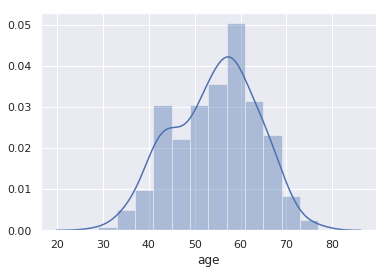

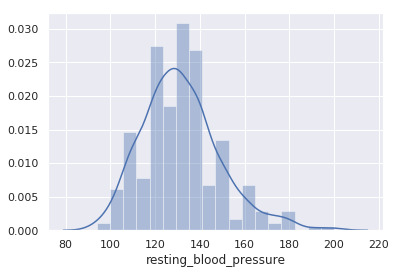

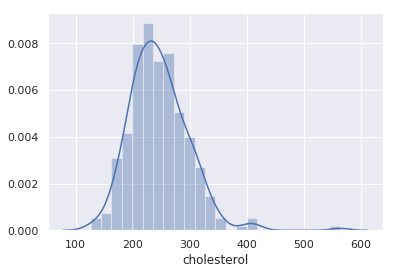

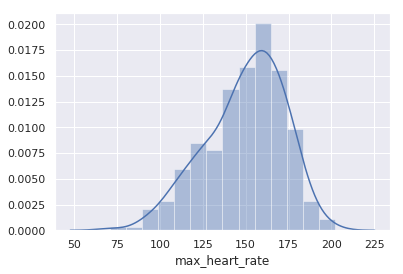

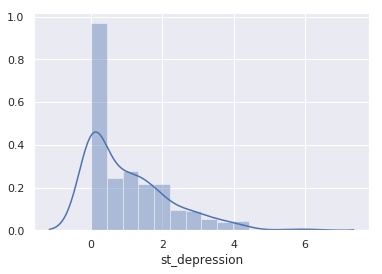

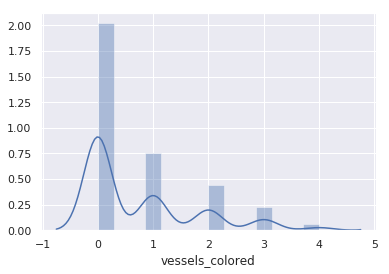

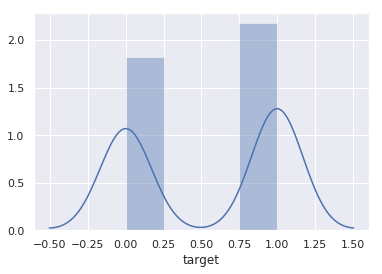

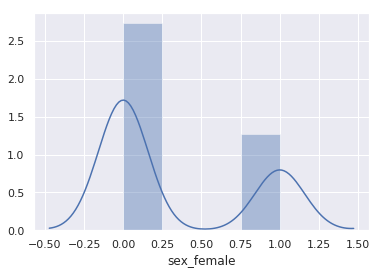

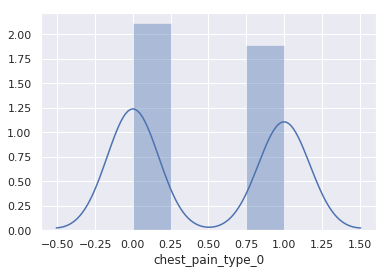

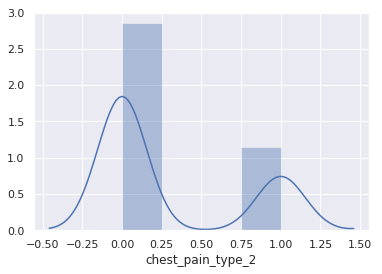

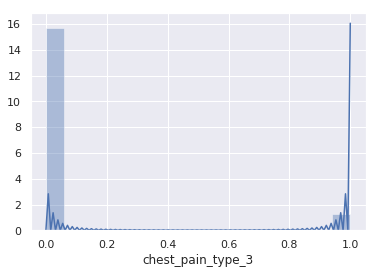

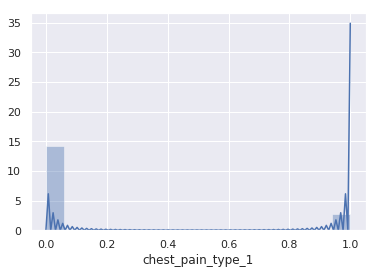

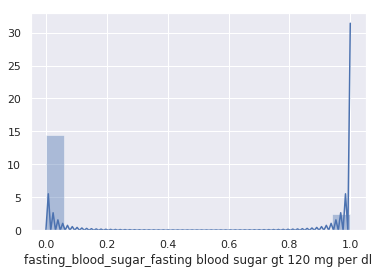

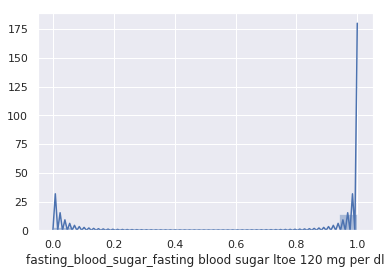

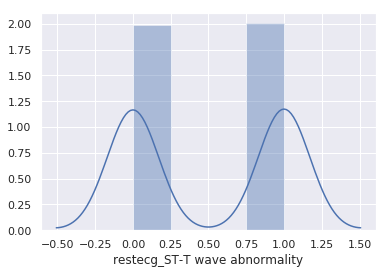

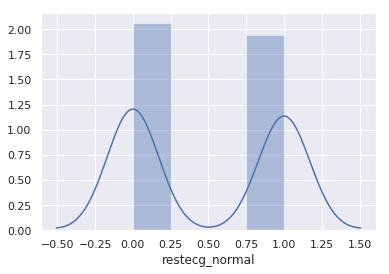

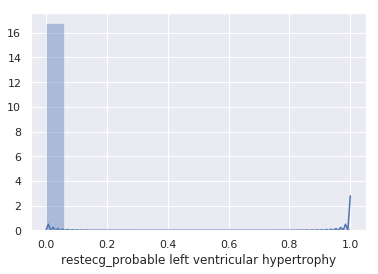

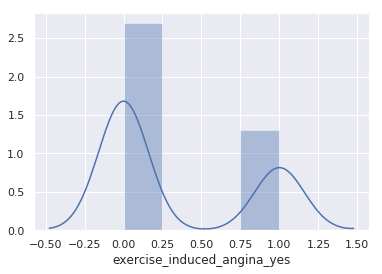

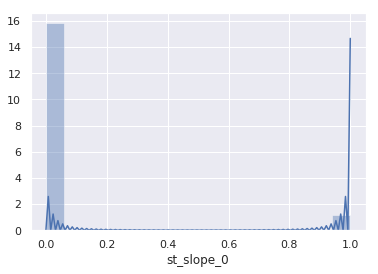

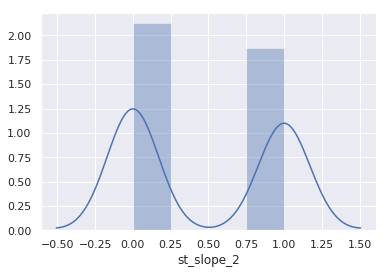

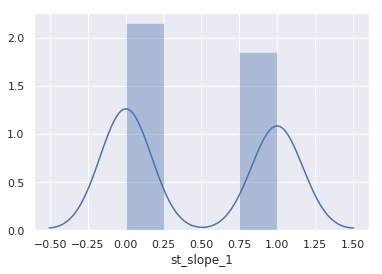

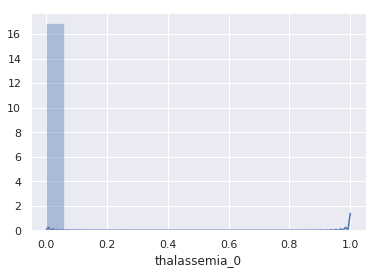

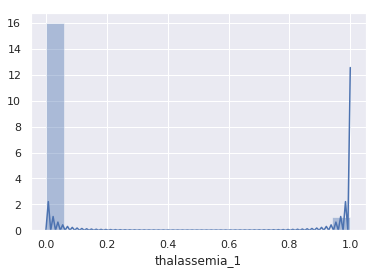

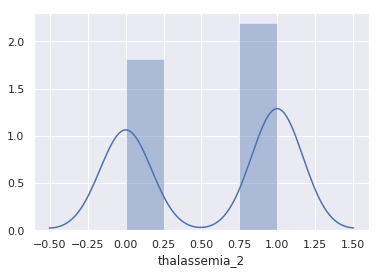

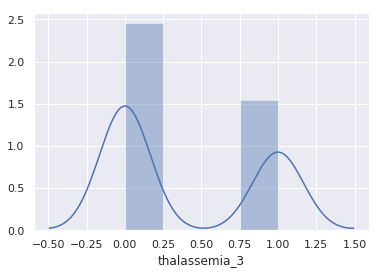

In [11]:
# plot a histogram for each variable in the model to understand distributions

pd.set_option('display.max_rows', 50)
for column in hd.columns:
    sns.distplot(hd[column])
    plt.show()

Notice the imbalance in observations by sex which we might typically expect to be closer to 50/50

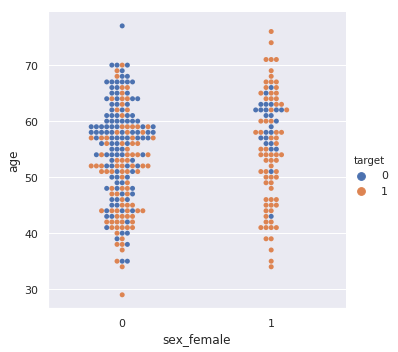

In [10]:
# further explore distribution by sex

sns.catplot(x="sex_female", y="age", hue="target",
            kind="swarm", data=hd);
plt.show()

Women in the study appear to have a lower number of obersations but a higher percentage of observations positive for heart disease.

Both men and women in the study appear to have a higher probability of heart disease at a younger age.

Perhaps younger individuals and women are less likely to go to the hospital for heart disease but have higher rates of positive heart disease identification when they do visit.

In [12]:
# table summarizing rates of heart disease identification by gender

pd.crosstab(hd.sex_female, hd.target).apply(lambda r: r/r.sum(), axis=1)

target,0,1
sex_female,,
0,0.550725,0.449275
1,0.250000,0.750000


75% of women in our dataset have heart disease.
Only 45% of men have heart disease.

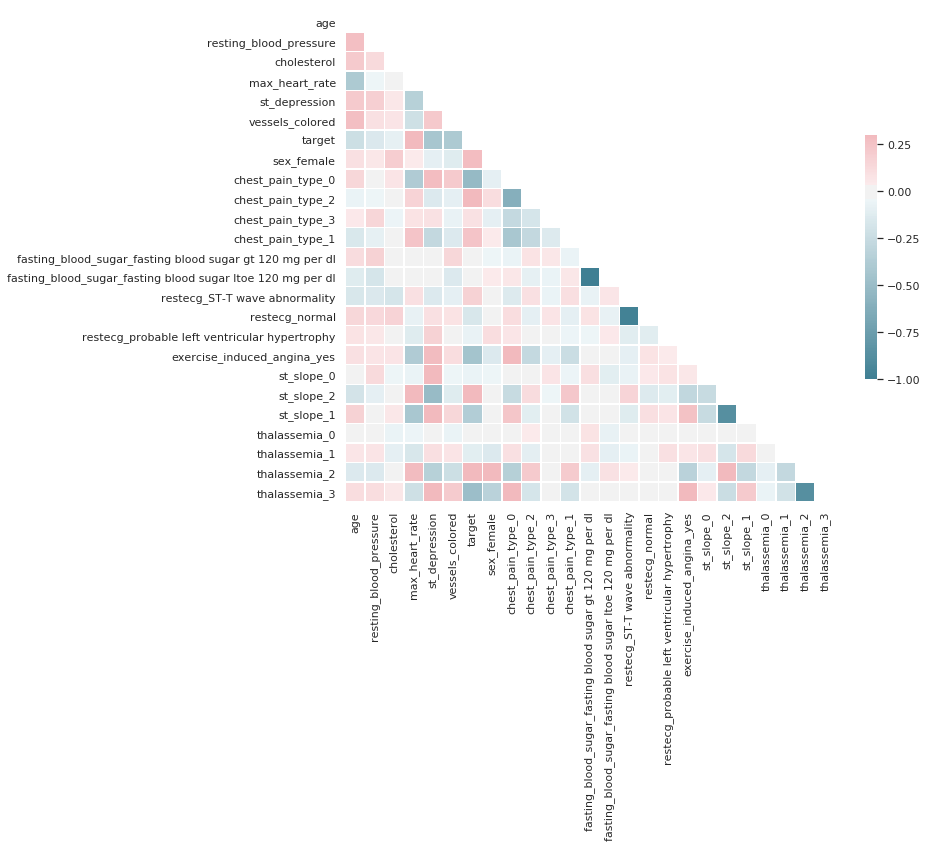

In [42]:
# produce a correlation matrix to observe relationship between each feature and the target

sns.set(style="white")

# compute the correlation matrix

corr = hd.corr()

# generate a mask for the upper triangle

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure

f, ax = plt.subplots(figsize=(11, 9))

# generate a custom diverging colormap

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


#### features demonstrating strong positive correlation with the target:
    st_depression
    vessels colored
    chest_pain_type_0
    exercise_induced_angina_yes
    st_slope_1
    thalassemia_3

#### features demonstrating strong negative correlation with the target:
    max_heart_rate
    chest_pain_type_2
    st_slope_2
    thalassemia_2

## 2) Create models

In [19]:
# create dataframe for model features

x = hd.drop('target',axis=1)
x.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate,st_depression,vessels_colored,sex_female,chest_pain_type_0,chest_pain_type_2,chest_pain_type_3,chest_pain_type_1,fasting_blood_sugar_fasting blood sugar gt 120 mg per dl,fasting_blood_sugar_fasting blood sugar ltoe 120 mg per dl,restecg_ST-T wave abnormality,restecg_normal,restecg_probable left ventricular hypertrophy,exercise_induced_angina_yes,st_slope_0,st_slope_2,st_slope_1,thalassemia_0,thalassemia_1,thalassemia_2,thalassemia_3
0,63,145,233,150,2.3,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0
1,37,130,250,187,3.5,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0
2,41,130,204,172,1.4,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0
3,56,120,236,178,0.8,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0
4,57,120,354,163,0.6,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,0


In [20]:
# create series for target variable

y = hd['target']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [21]:
# create validation set to evaluate final model

from sklearn.model_selection import train_test_split

x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.2, random_state=0)

In [22]:
# define parameters for 10-fold cross validation
# selecting k = 10 given the rather small size of this dataset

from sklearn.model_selection import KFold
cv = KFold(n_splits=10, random_state=0, shuffle=True)

In [23]:
# standardize features prior to use in models

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
x_train_standard = pd.DataFrame(StandardScaler().fit_transform(x_train)
                          , index=x_train.index, columns=x_train.columns)
x_validation_standard = pd.DataFrame(StandardScaler().fit_transform(x_validation)
                                     , index=x_validation.index, columns=x_validation.columns)

In [24]:
def raw_model_output():
    """fits model and generates a cross-validated ROC curve for raw data (non-standardized)
    """
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    # fit model
    i = 0
    for build, test in cv.split(x_train,y_train):
        classifier.fit(x_train.iloc[build], y_train.iloc[build])
        probas_ = classifier.fit(x_train.iloc[build], y_train.iloc[build]).predict_proba(x_train.iloc[test])
        
        # compute receiver operator curve (ROC) and area the curve(AUC)
        fpr, tpr, thresholds = roc_curve(y_train.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    
    # plot ROC
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Raw receiver operating characteristic')
    plt.legend(loc="lower right", fontsize="x-small")
    plt.show()

In [25]:
def standardized_model_output():
    """fits model and generates a cross-validated ROC curve for standardized data
    """
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    # fit model
    i = 0
    for build, test in cv.split(x_train_standard,y_train):
        classifier.fit(x_train_standard.iloc[build], y_train.iloc[build])
        probas_ = classifier.fit(x_train_standard.iloc[build]
                                 , y_train.iloc[build]).predict_proba(x_train_standard.iloc[test])
        
        # compute receiver operator curve (ROC) and area the curve(AUC)
        fpr, tpr, thresholds = roc_curve(y_train.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    
    # plot ROC
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Standardized receiver operating characteristic')
    plt.legend(loc="lower right", fontsize="x-small")
    plt.show()

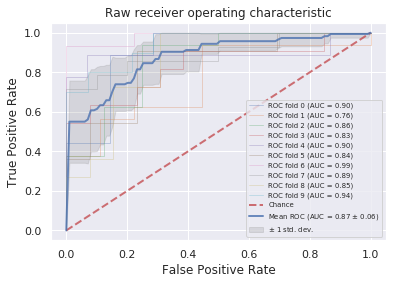

In [18]:
# gaussian naive bayes

from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
parameters = {
        'var_smoothing': (1e-9,1e-5,.01,.1,.5,1),
}
classifier = GridSearchCV(estimator=model, cv=cv, param_grid=parameters, n_jobs=-1)

raw_model_output()

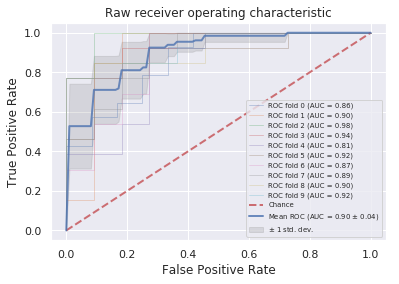

In [42]:
# logistic regression with l1 penalty and liblinear solver

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0, multi_class='ovr', solver='liblinear', penalty='l1')
parameters = {
        'C': (0.01,0.1,0.5,0.9,0.99),
}
classifier = GridSearchCV(estimator=model, cv=cv, param_grid=parameters, n_jobs=-1)

raw_model_output()

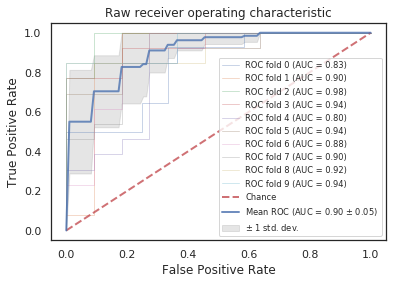

In [23]:
# logistic regression with l2 penalty and newton-cfg solver

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0, multi_class='ovr', solver='newton-cg', penalty='l2')
parameters = {
        'C': (0.01,0.1,0.5,0.9,0.99),
}
classifier = GridSearchCV(estimator=model, cv=cv, param_grid=parameters, n_jobs=-1)

raw_model_output()

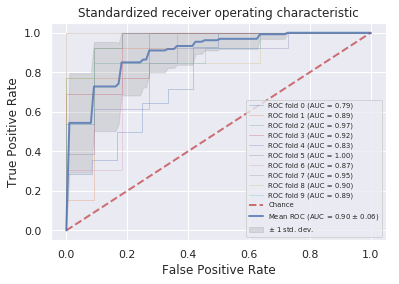

In [15]:
# support vector classifier

from sklearn.svm import SVC

model = SVC(random_state=0, probability=True)
parameters = {
        'C': (0.01,0.1,0.5,0.9,0.99),
        'kernel': ('rbf', 'sigmoid'),
        'gamma': (0.001,0.01,0.05,0.1,0.5,0.9),
}
classifier = GridSearchCV(estimator=model, cv=cv, param_grid=parameters, n_jobs=-1)

standardized_model_output()

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/mod

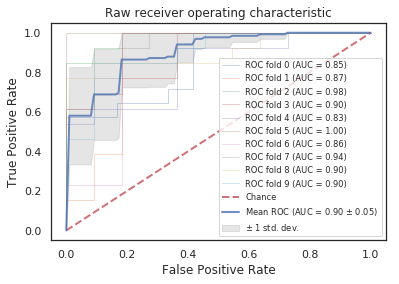

In [26]:
# random forest

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
parameters = {
        'max_depth': (2,6),
        'min_samples_leaf': (2,5),
        'min_samples_split': (2,6,10),
}
classifier = GridSearchCV(estimator=model, cv=cv, param_grid=parameters, n_jobs=-1)

raw_model_output()

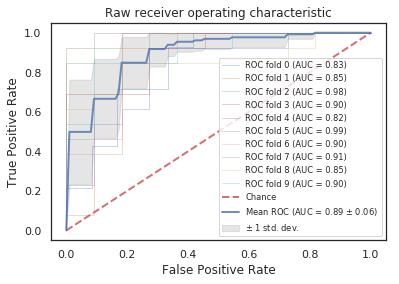

In [46]:
# linear discriminant analysis with svd solver

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis(solver='svd')
parameters = {
           'store_covariance': (0.01,0.5,0.99),
           'tol': (0.01,0.5,0.99)
}
classifier = GridSearchCV(estimator=model, cv=cv, param_grid=parameters, n_jobs=-1)

raw_model_output()

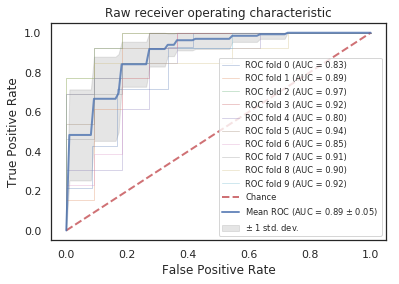

In [45]:
# linear discriminant analysis with lsqr solver

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis(solver='lsqr')
parameters = {
           'shrinkage': (0,0.01,0.1,0.5,0.9,1)
}
classifier = GridSearchCV(estimator=model, cv=cv, param_grid=parameters, n_jobs=-1)

raw_model_output()

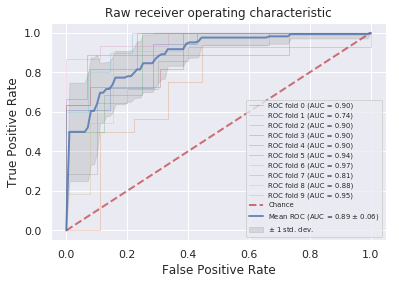

best params
learning_rate:  0.01
max_features:  1
max_depth:  6


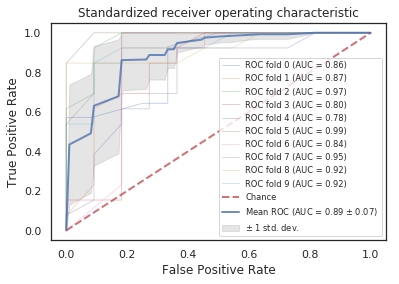

In [47]:
# k nearest neighbors

from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
parameters = {
           'n_neighbors': (2,6,10,15,20,25),
           'leaf_size': (1,2,3,4,5)
}
classifier = GridSearchCV(estimator=model, cv=cv, param_grid=parameters)

standardized_model_output()

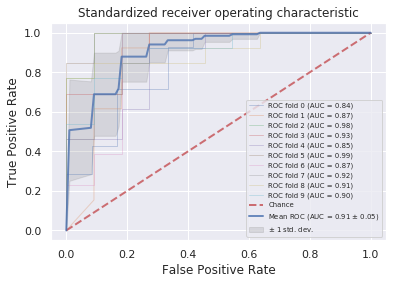

In [33]:
# stochastic gradient descent

from sklearn.linear_model import SGDClassifier

model = SGDClassifier(random_state=0, penalty='elasticnet', loss='modified_huber', n_jobs=-1)
parameters = {
           'alpha': (0.01,0.5,0.99),
           'l1_ratio': (0,0.1,0.5,0.9,1),
}
classifier = GridSearchCV(estimator=model, cv=cv, param_grid=parameters, n_jobs=-1)

standardized_model_output()

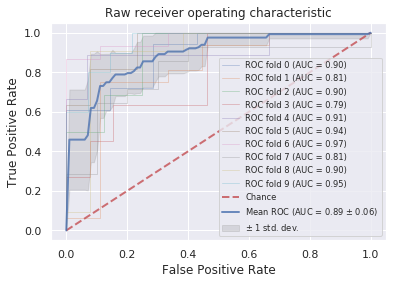

best params
learning_rate:  0.01
max_features:  1
max_depth:  6


In [26]:
# gradient boosted machine

from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=0, n_estimators=100)
parameters = {
           'learning_rate': (0.01,0.5,0.99),
           'max_features': (1,5),
           'max_depth': (2,6)
}
classifier = GridSearchCV(estimator=model, cv=cv, param_grid=parameters, n_jobs=-1)

raw_model_output()

best_parameters = classifier.best_estimator_.get_params()
lr = best_parameters['learning_rate']
mf = best_parameters['max_features']
md = best_parameters['max_depth']
print("best params")
print("learning_rate: ",lr)
print("max_features: ",mf)
print("max_depth: ", md)

## 3) Select final model and evaluate output

Many of the top performing models we tested achieved a similar AUC value. Without much separation, Gradient Boosting will be used in the final model given its strong performance in many classification projects and its efficient runtime. Additionally, the non-linearity will allow for a better explanation of partial dependence plots later in this notebook. 

0
1
2
3
4
5
6
7
8
9


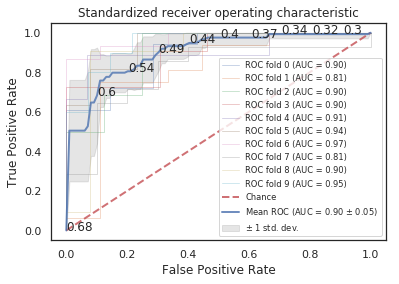

best params
learning_rate:  0.01
max_features:  1
max_depth:  6


In [54]:
# run final model on test data and tune parameters one last time for final model- stochastic gradient descent

model = GradientBoostingClassifier(random_state=0, n_estimators=100)
parameters = {
           'learning_rate': (0.01,0.5,0.99),
           'max_features': (1,5),
           'max_depth': (2,6)
}
classifier = GridSearchCV(estimator=model, cv=cv, param_grid=parameters, n_jobs=-1)

def final_model_parameters_output():
    """fits final model with additional parameter values and generates a cross-validated ROC curve
    """
    thresh = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    mean_thresh = np.linspace(0, 1, 100)
    
    # fit model
    i = 0
    for build, test in cv.split(x_train,y_train):
        classifier.fit(x_train.iloc[build], y_train.iloc[build])
        probas_ = classifier.fit(x_train.iloc[build]
                                 , y_train.iloc[build]).predict_proba(x_train.iloc[test])
        # compute receiver operator curve (ROC) and area the curve(AUC)
        fpr, tpr, thresholds = roc_curve(y_train.iloc[test], probas_[:, 1], drop_intermediate=False)
        tprs.append(interp(mean_fpr, fpr, tpr))
        thresh.append(interp(mean_fpr, fpr, thresholds))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        print(i)
        i += 1
        
    # plot ROC
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    mean_thresh = np.mean(thresh, axis=0)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Standardized receiver operating characteristic')
    plt.legend(loc="lower right", fontsize="x-small")
    for x, y, txt in zip(mean_fpr[::10], mean_tpr[::10], mean_thresh[::10]):
        plt.annotate(np.round(txt,2), (x, y))
    plt.show()

final_model_parameters_output()

# output best parameters
best_parameters = classifier.best_estimator_.get_params()
lr = best_parameters['learning_rate']
mf = best_parameters['max_features']
md = best_parameters['max_depth']
print("best params")
print("learning_rate: ",lr)
print("max_features: ",mf)
print("max_depth: ", md)

Given the importance of correctly identifying heart disease, our objective for this model is to maximize the True Positive Rate (aka Sensitivity) (TP / (TP + FN)) while minimizing the False Positive Rate (FP / (FP + TN)). 

This ensures that very few cases of heart disease go undetected, but the tradeoff is that individuals without heart disease will occasionally be flagged as likely having the disease and will need to go additional testing which will ultimately be unnecessary. 

To obtain these goals, we will set the cutoff threshold to 0.4, the point at the bend on the above ROC curve where the True Positive Rate is nearly maximized and the False Positive Rate has not yet skyrocketed to 1. 

AUC = 0.88


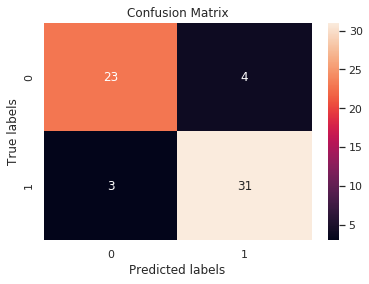

In [55]:
# build final model

model = GradientBoostingClassifier(random_state=0, n_estimators=1000, learning_rate=lr,
                                   max_features=mf, max_depth=md)
classifier = model.fit(x_train, y_train)
final_decisions = (classifier.predict_proba(x_validation)[:,1] >= (0.44)).astype(int)

# compute area under the curve(AUC)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fpr, tpr, thresholds = roc_curve(y_validation, final_decisions)
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
print('AUC = %0.2f' % (mean_auc))

# confusion matrix 
cm = confusion_matrix(y_validation, final_decisions)     
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

Results from the final model's performance on the validation set show that we were able to successfully flag 31 of the 34 cases of heart disease resulting in a True Positive Rate of 91%. 

Of the 27 cases without heart disease, we incorrectly labeled 4 leading to a False Positive Rate of 15%. 

In [64]:
# feature importance

import eli5
from eli5.sklearn import PermutationImportance

features = x_validation.columns.values.tolist()

perm = PermutationImportance(model, random_state=0).fit(x_validation,y_validation)
eli5.show_weights(perm, feature_names=features, top=30)

Weight,Feature
0.0557 ± 0.0445,vessels_colored
0.0459 ± 0.0525,chest_pain_type_0
0.0393 ± 0.0334,thalassemia_2
0.0295 ± 0.0245,cholesterol
0.0295 ± 0.0321,thalassemia_3
0.0295 ± 0.0382,st_slope_1
0.0230 ± 0.0445,st_depression
0.0197 ± 0.0245,chest_pain_type_2
0.0164 ± 0.0293,max_heart_rate
0.0164 ± 0.0207,exercise_induced_angina_yes


The feature importance list shows that many of the features in our model were positively related to indications of heart disease. 

The top positive indicators include vessels_colored, chest_pain_type_0, thalassemia_2, cholesterol, thalassemia_3, and st_slope_1.

restecg_ST-T wave abnormality was the only negatively related indicator. 

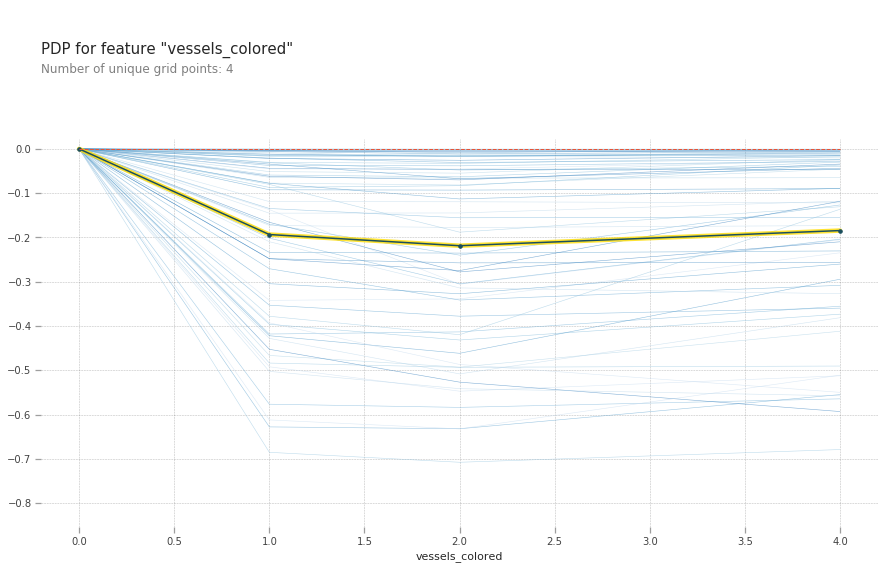

In [59]:
# partial dependence plots

#%matplotlib inline

from pdpbox import pdp, info_plots

plot_feature = 'vessels_colored'

pdp_isolate = pdp.pdp_isolate(model=model,
                              dataset=x_validation,
                              model_features=features,
                              feature=plot_feature)

pdp.pdp_plot(pdp_isolate, plot_feature, plot_lines=True)
plt.show()

Partial dependence plots visualize the relationship between the target variable and a feature of interest. Most packages do this by building the model while averaging other predictor variavle except the feature of interest. These plots can help explain how the likelihood of heart disease presence changes for different values of each of our features. 

Note - because our final model selected was Stochastic Gradient Descent, which is a linear model, these plots will unfortunately appear as straight lines. For other models, the lines would include fluctuations. Still, there is value in understanding the linear relationships that our model developed. 

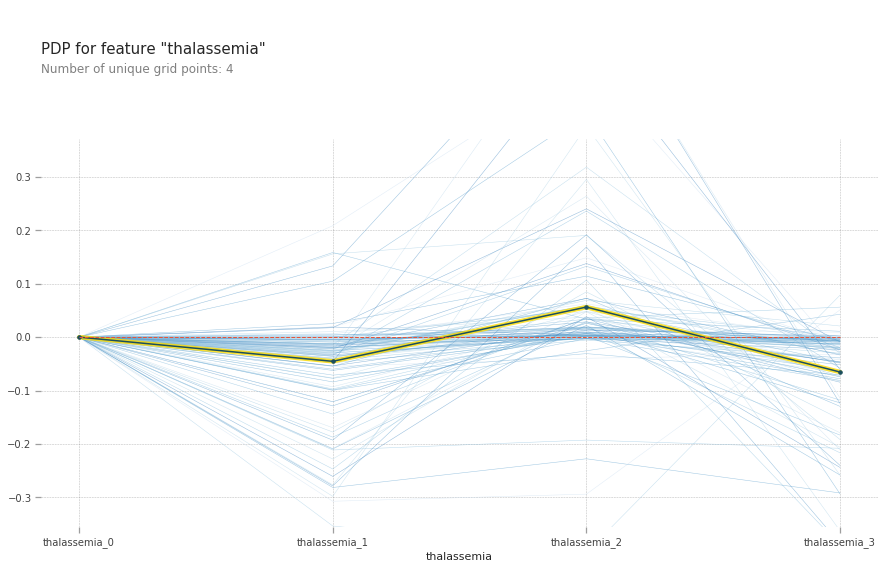

In [60]:
# partial dependence plot for one-hot-encoded variables

pdp_onehot = pdp.pdp_isolate(model=model,
                             dataset=x_train,
                             model_features=features,
                             feature=['thalassemia_0',
                                      'thalassemia_1',
                                      'thalassemia_2',
                                      'thalassemia_3'])
pdp.pdp_plot(pdp_onehot, 'thalassemia', center=True, plot_lines=True,frac_to_plot=100)
plt.show()

# make comments for second partial dependence plot

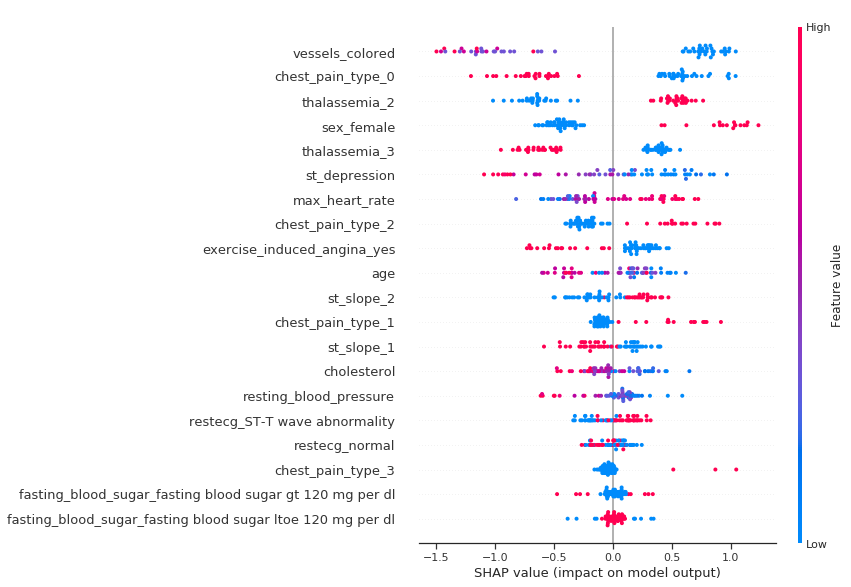

In [65]:
# shapley summary plot

import shap

explainer = shap.TreeExplainer(model, x_train, feature_dependence="independent")
shap_values = explainer.shap_values(x_validation)
x_validation_array = x_validation.values # we need to pass a dense version for the plotting functions

shap.summary_plot(shap_values, x_validation_array, feature_names=features)


# make comments for shapley summary plot

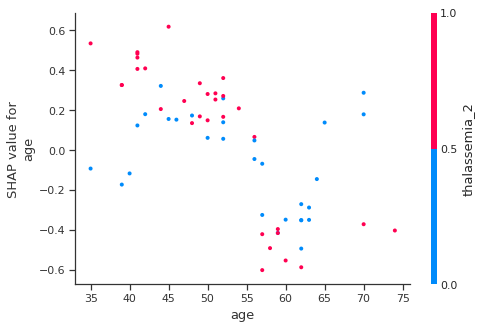

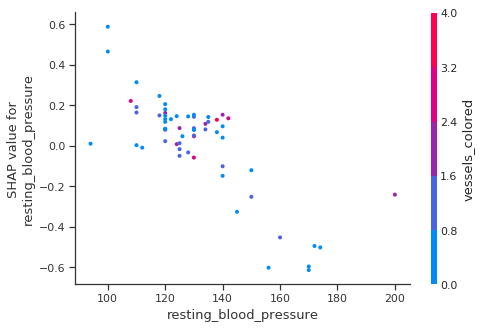

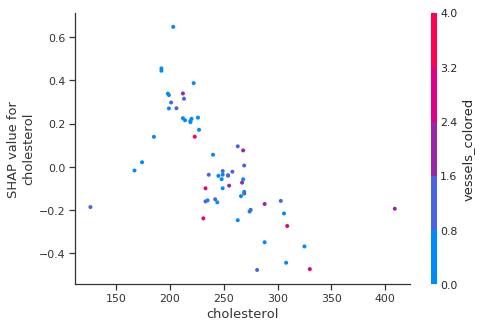

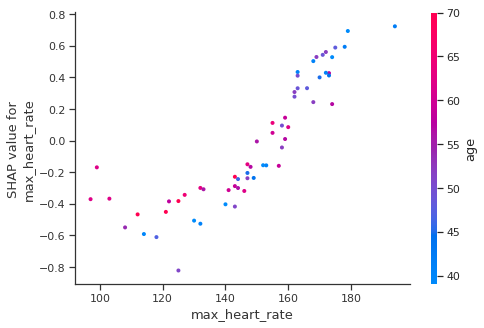

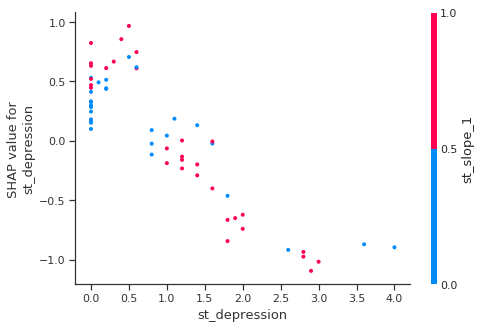

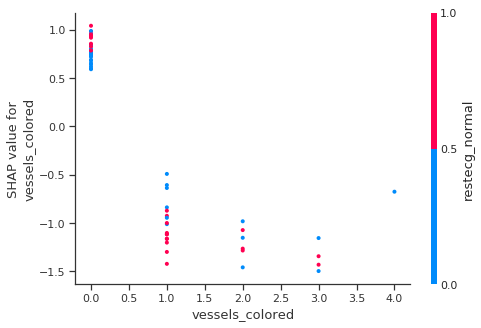

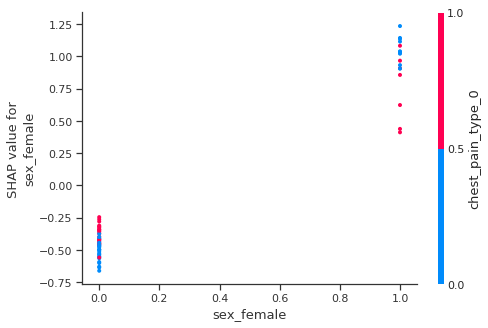

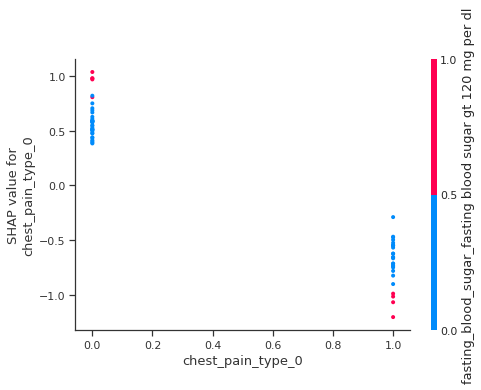

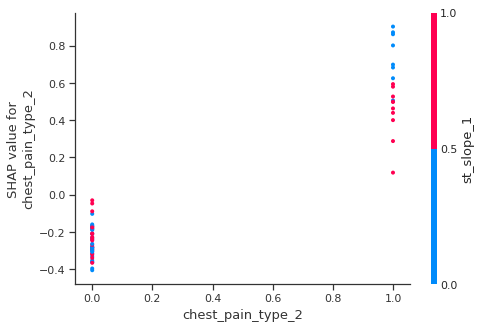

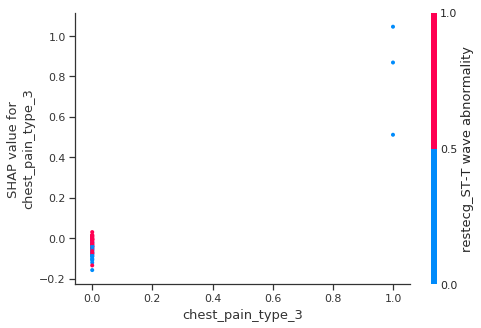

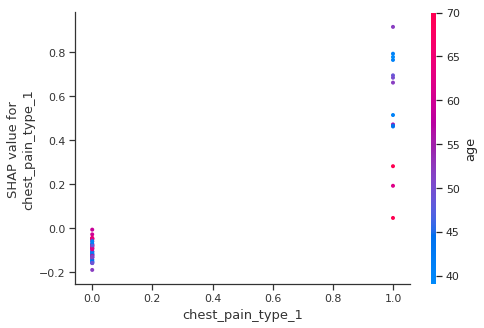

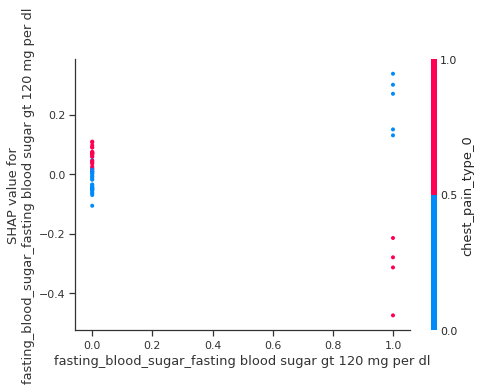

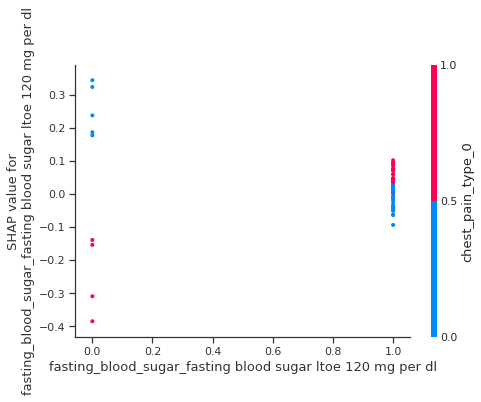

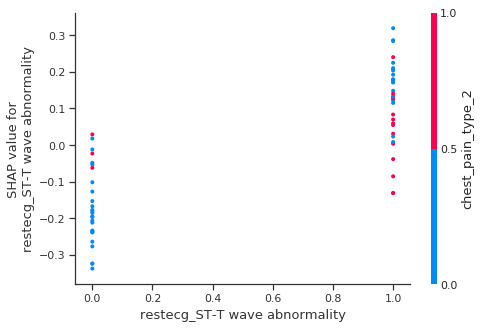

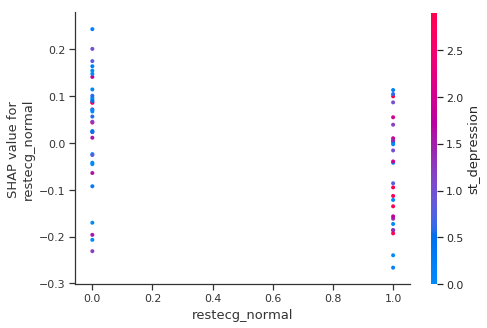

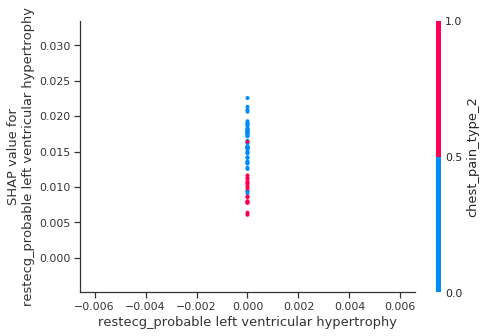

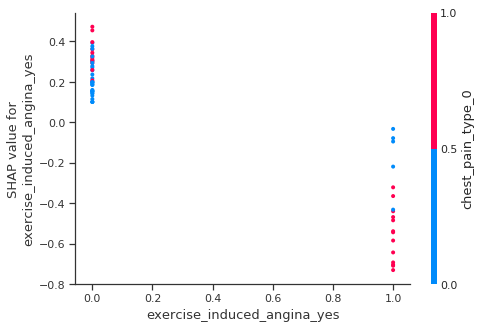

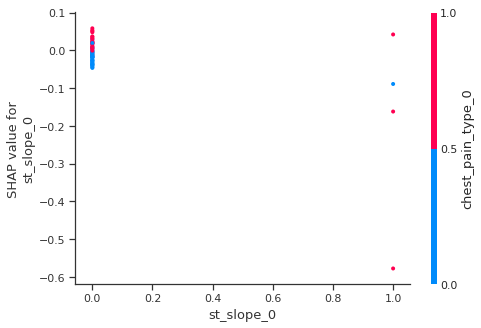

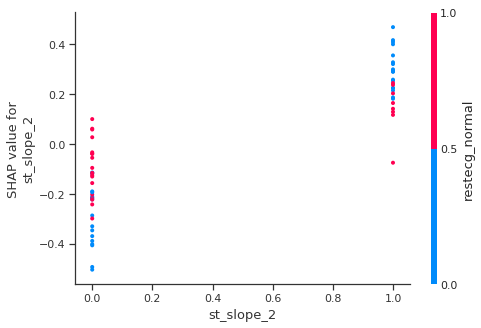

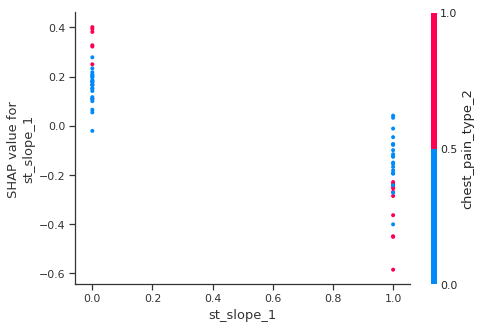

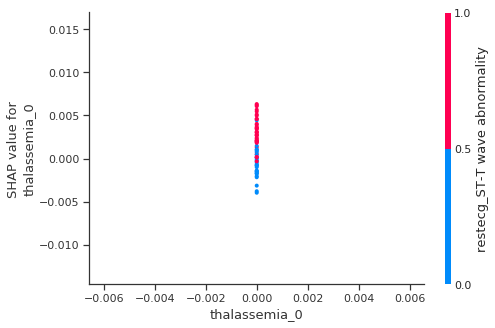

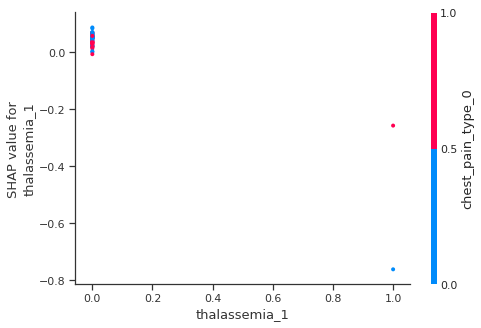

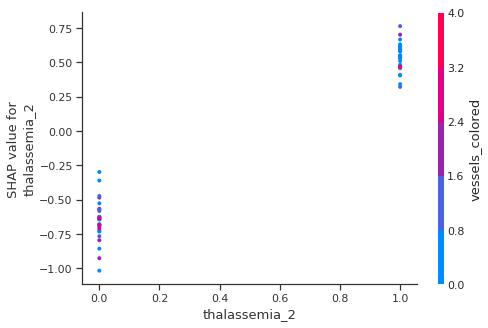

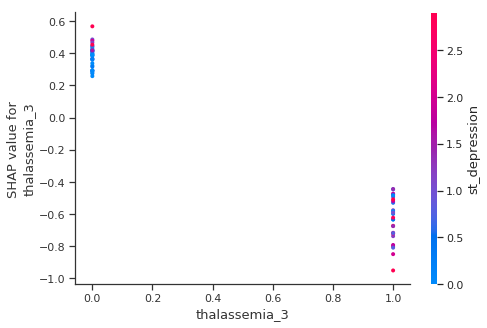

In [66]:
# shapley dependence plot

for name in x_train.columns:
     shap.dependence_plot(name, shap_values, x_validation, display_features=x_validation)

# make comments for shapley dependence plot

In [67]:
# shapley force plot

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1],x_validation.iloc[[1]])

In [ ]:
import lime
from lime import lime_tabular

# make comments for shaplely force plot